# YOUR PROJECT TITLE

Imports and set magics:

In [1]:
import numpy as np
from scipy import optimize
import sympy as sm
import matplotlib.pyplot as plt


# autoreload modules when code is run
%load_ext autoreload
%autoreload 2

# local modules
import modelproject
from modelproject import SolowModelClass 
model = SolowModelClass()

initializing the model:
calling .setup()


# Model description

**Write out the model in equations here.** 

Make sure you explain well the purpose of the model and comment so that other students who may not have seen it before can follow.  

$Y_t = [1-D]K_t^\alpha (A_t L_t)^{1-\alpha}, 0 <\alpha<1$

$D=1-\frac{1}{1+\sigma{(\Delta T)}^2}, \sigma > 0$

$K_{t+1}=s Y_t+(1-\delta) K_t, 0<s<1,0<\delta<1,K_0>0$

$A_{t+1}=(1+g)A_t, A_0>0$

$L_{t+1}=(1+n)A_t, L_0>0$

Udledning af transistionsligning 
Fase diagram

## Analytical solution

If your model allows for an analytical solution, you should provide here.

You may use Sympy for this. Then you can characterize the solution as a function of a parameter of the model.

To characterize the solution, first derive a steady state equation as a function of a parameter using Sympy.solve and then turn it into a python function by Sympy.lambdify. See the lecture notes for details. 

In [2]:
model.solve_analytical_ss()

((-delta - g*n - g - n)/(s*(D - 1)))**(1/(alpha - 1))

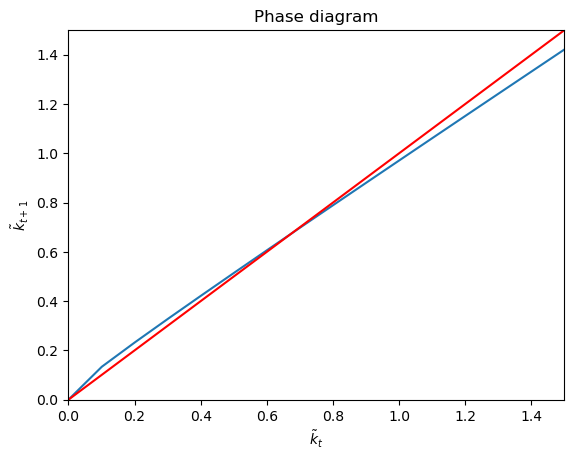

In [3]:
# defining model parameters
s = 0.2
g = 0.02
n = 0.01
alpha = 0.33
delta = 0.1
sigma = 0.5
d = 0.5

# define the objective function with the production function integrated
kt1 = lambda k:(s*(1-d)*k**alpha + (1-delta)*k)/((1+g)*(1+n))

# generate a range of values for kt1
kt1_range = np.linspace(0, 10, 100)

# create a plot of the objective function
plt.plot(kt1_range, kt1(kt1_range))

# plot a line with slope 1 to represent the 45-degree line
plt.plot([0, 1.5], [0, 1.5], color='r')

# set the x and y limits
plt.xlim(0, 1.5)
plt.ylim(0, 1.5)

# label the axes
plt.xlabel(r'$\tilde k_t$')
plt.ylabel(r'$\tilde k_{t+1}$')

# set title
plt.title('Phase diagram')

# show the plot
plt.show()

## Numerical solution

You can always solve a model numerically. 

Define first the set of parameters you need. 

Then choose one of the optimization algorithms that we have gone through in the lectures based on what you think is most fitting for your model.

Are there any problems with convergence? Does the model converge for all starting values? Make a lot of testing to figure these things out. 

# Further analysis

Make detailed vizualizations of how your model changes with parameter values. 

Try to make an extension of the model. 

In [4]:
# create a list of values for d
d_vec = np.linspace(0,1,5,endpoint=False)

# create an empty list to store the results
k_ss_list = []
y_ss_list = []
relative_y_ss_list = []

for d in d_vec:
    model.val.d = d
    k_ss, y_ss = model.solve_num_ss()
    k_ss_list.append(k_ss)
    y_ss_list.append(y_ss)
    rel_y_ss = y_ss/y_ss_list[0]*100
    relative_y_ss_list.append(rel_y_ss)

    print(f'd = {d:.1f}: \n Steady state for k is {k_ss:.1f} \n steady state for y is {y_ss:.1f} \n Steady state output per worker relative to a world without climate change is {rel_y_ss:.1f}% \n')

d = 0.0: 
 Steady state for k is 1.9 
 steady state for y is 1.2 
 Steady state output per worker relative to a world without climate change is 100.0% 

d = 0.2: 
 Steady state for k is 1.4 
 steady state for y is 0.9 
 Steady state output per worker relative to a world without climate change is 71.7% 

d = 0.4: 
 Steady state for k is 0.9 
 steady state for y is 0.6 
 Steady state output per worker relative to a world without climate change is 46.7% 

d = 0.6: 
 Steady state for k is 0.5 
 steady state for y is 0.3 
 Steady state output per worker relative to a world without climate change is 25.5% 

d = 0.8: 
 Steady state for k is 0.2 
 steady state for y is 0.1 
 Steady state output per worker relative to a world without climate change is 9.1% 



In the following we wish to simulate the development in...

In [20]:
model.simulate()

AttributeError: 'types.SimpleNamespace' object has no attribute 'fracY'

NameError: name 'K_lag' is not defined

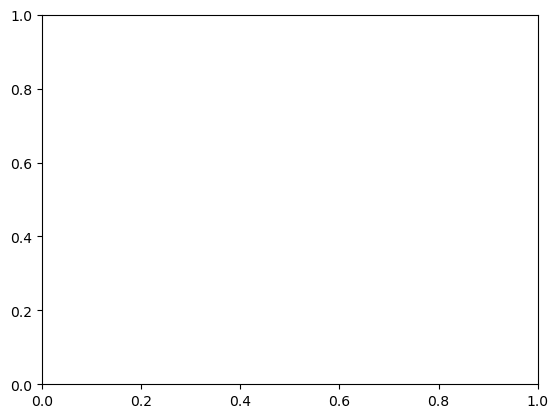

In [19]:
simT_fig = 100 # first 100 periods
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.plot(np.arange(simT_fig),K_lag[:simT_fig],label='$\\hat{y}_t$')
ax.set_xlabel('time')
ax.legend(frameon=True);

# Conclusion

Add concise conclusion. 